In [54]:
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoTokenizer, AutoModelForCausalLM
import torch
import nlp
import shap
from datasets import load_dataset
import scipy as sp

In [55]:
# dataset = load_dataset("multi_nli")
dataset = load_dataset("snli")

Reusing dataset snli (C:\Users\v-maxtell\.cache\huggingface\datasets\snli\plain_text\1.0.0\bb1102591c6230bd78813e229d5dd4c7fbf4fc478cec28f298761eb69e5b537c)


In [56]:
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
})


In [57]:
dataset['train']['premise'][0]

'A person on a horse jumps over a broken down airplane.'

In [58]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli", use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli")

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [59]:
example_ind = 6
premise, hypothesis, label = dataset['train']['premise'][example_ind], dataset['train']['hypothesis'][example_ind], dataset['train']['label'][example_ind]
print(premise)
print(hypothesis)
print(label)
p2, h2, l2 = (
    dataset["train"]["premise"][example_ind + 1],
    dataset["train"]["hypothesis"][example_ind + 1],
    dataset["train"]["label"][example_ind + 1]
)
print(p2)
print(h2)
print(l2)

A boy is jumping on skateboard in the middle of a red bridge.
The boy skates down the sidewalk.
2
A boy is jumping on skateboard in the middle of a red bridge.
The boy does a skateboarding trick.
0


In [60]:
# run through model pre-trained on MNLI
input_ids = tokenizer.encode(premise, hypothesis, return_tensors='pt')
print(input_ids)
logits = model(input_ids)[0]

probs = logits.softmax(dim=1)
p1, p2, p3 = probs[:,0].item() * 100, probs[:,1].item()*100, probs[:,2].item()*100
print('Contradiction Probability: {p1:0.2f}%, Neutral Probability: {p2:0.2f}%, Entailment Probability: {p3:0.2f}%'.format(p1 = p1, p2 = p2, p3=p3))
ind_to_label = {0: 'entailment', 1: 'neural', 2: 'contradiction'}
true_label = ind_to_label[label]
print('The true label is: {true_label}'.format(true_label=true_label))

tensor([[    0,   250,  2143,    16,  9755,    15, 12800,  4929,    11,     5,
          1692,     9,    10,  1275,  4081,     4,     2,     2,   133,  2143,
          2972,  1626,   159,     5, 15032,     4,     2]])
Contradiction Probability: 99.95%, Neutral Probability: 0.03%, Entailment Probability: 0.02%
The true label is: contradiction


In [61]:
id2label = ind_to_label
labels=list(id2label.values())
label2id = {}
for i,label in enumerate(labels):
    label2id[label]=i

In [62]:
def f(x):
    tv = torch.tensor([tokenizer.encode(v[0], v[1]) for v in x])
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

In [63]:
explainer = shap.Explainer(f,tokenizer)

In [64]:
shap_values_multiclass = explainer([(premise, hypothesis)])
shap_values_multiclass

.values =
array([[[-2.83558453e-02,  4.12395988e-02, -1.95826786e-01],
        [-2.83558453e-02,  4.12395988e-02, -1.95826786e-01],
        [-2.83558453e-02,  4.12395988e-02, -1.95826786e-01],
        [-2.83558453e-02,  4.12395988e-02, -1.95826786e-01],
        [ 2.38082347e-01, -1.31364068e-01, -2.20297370e-01],
        [ 2.38082347e-01, -1.31364068e-01, -2.20297370e-01],
        [-9.55943781e-01,  6.72986107e-01,  3.21110971e-01],
        [-9.55943781e-01,  6.72986107e-01,  3.21110971e-01],
        [ 2.59267928e-01, -1.93415351e-01, -3.26685913e-01],
        [ 2.59267928e-01, -1.93415351e-01, -3.26685913e-01],
        [ 5.30555242e-01, -4.14191203e-01, -6.68954104e-01],
        [ 5.31623506e-01, -4.17025374e-01, -6.65835738e-01],
        [ 6.58997750e-01, -5.23975204e-01, -4.60286859e-01],
        [ 6.58997750e-01, -5.23975204e-01, -4.60286859e-01],
        [ 6.58997750e-01, -5.23975204e-01, -4.60286859e-01],
        [ 6.58997750e-01, -5.23975204e-01, -4.60286859e-01],
        [ 1.96

In [52]:
def custom_masked_bar_plot(class_index,mask_type,viz_type):
    #determine type of operation on the explanation object
    if viz_type=='mean':
        compute_shap=copy.copy(shap_values_multiclass.mean(0))
    if viz_type=='sum':
        compute_shap=copy.copy(shap_values_multiclass.sum(0))
    if viz_type=='abs_mean':
        compute_shap=copy.copy(shap_values_multiclass.abs.sum(0))
    if viz_type=='abs_sum':
        compute_shap=copy.copy(shap_values_multiclass.abs.sum(0))
    #create a mask to visualize either positively or negatively contributing features
    if mask_type=='pos':
        mask=compute_shap.values[:,class_index]>=0
    else:
        mask=compute_shap.values[:,class_index]<=0
    #slice values related to a given class
    compute_shap.values=compute_shap.values[:,class_index][mask]
    compute_shap.feature_names=list(np.array(compute_shap.feature_names)[mask])
    #plot
    shap.plots.bar(compute_shap.abs,order=shap.Explanation.identity)
def text_plot(class_index,start_idx,end_idx):
    shap_values = copy.copy(shap_values_multiclass[:])
    #slice values related to a given class
    if len(shap_values.base_values.shape) == 1:
        shap_values.values = shap_values.values[:,class_index]
        shap_values.hierarchical_values = shap_values.hierarchical_values[:,class_index]
        shap_values.base_values = shap_values.base_values[class_index]
    else:
        for i in range(start_idx,end_idx):
            shap_values.values[i] = shap_values.values[i][:,class_index]
            shap_values.hierarchical_values[i] = shap_values.hierarchical_values[i][:,class_index]
        shap_values.base_values = shap_values.base_values[:,class_index]
    #plot
    shap.plots.text(shap_values[start_idx:end_idx])

In [53]:
label='contradiction'
inp = shap_values_multiclass[0][:,label2id[label]].abs
print(inp.clustering)
shap.plots.bar(inp)

[[ 0.  1. -1.  2.]
 [ 2.  3. 12.  2.]
 [ 4.  5. 12.  2.]
 [ 6.  7. -1.  2.]
 [ 8.  9. 12.  2.]
 [10. 11. 12.  2.]
 [12. 13. 12.  2.]
 [16. 17. 12.  2.]
 [18. 19. 12.  2.]
 [20. 21. -1.  2.]
 [22. 23. 12.  2.]
 [33. 14. 13.  3.]
 [37. 24. 13.  3.]
 [27. 28. 14.  4.]
 [29. 30. 14.  4.]
 [31. 32. 14.  4.]
 [34. 35. -1.  4.]
 [38. 15. -1.  4.]
 [36. 39. 15.  5.]
 [45. 25. -1.  6.]
 [40. 41. 18.  8.]
 [42. 44. 18.  8.]
 [43. 46. 20. 10.]
 [47. 48. 26. 16.]
 [49. 26. 41. 11.]
 [50. 51. 57. 27.]]


ValueError: Linkage 'Z' contains negative distances.

In [1]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [6]:
Z = np.array([[ 0.,  1., 12.,  2.],
       [ 2.,  3., 12.,  2.],
       [ 4.,  5., 12.,  2.],
       [ 6.,  7., 12.,  2.],
       [ 8.,  9., 12.,  2.],
       [10., 11., 12.,  2.],
       [12., 13., 12.,  2.],
       [16., 17., 12.,  2.],
       [18., 19., 12.,  2.],
       [20., 21., 12.,  2.],
       [22., 23., 12.,  2.],
       [33., 14., 13.,  3.],
       [37., 24., 13.,  3.],
       [27., 28., 14.,  4.],
       [29., 30., 14.,  4.],
       [31., 32., 14.,  4.],
       [34., 35., 14.,  4.],
       [38., 15., 15.,  4.],
       [36., 39., 15.,  5.],
       [45., 25., 17.,  6.],
       [40., 41., 18.,  8.],
       [42., 44., 18.,  8.],
       [43., 46., 20., 10.],
       [47., 48., 26., 16.],
       [49., 26., 41., 11.],
       [50., 51., 57., 27.]])


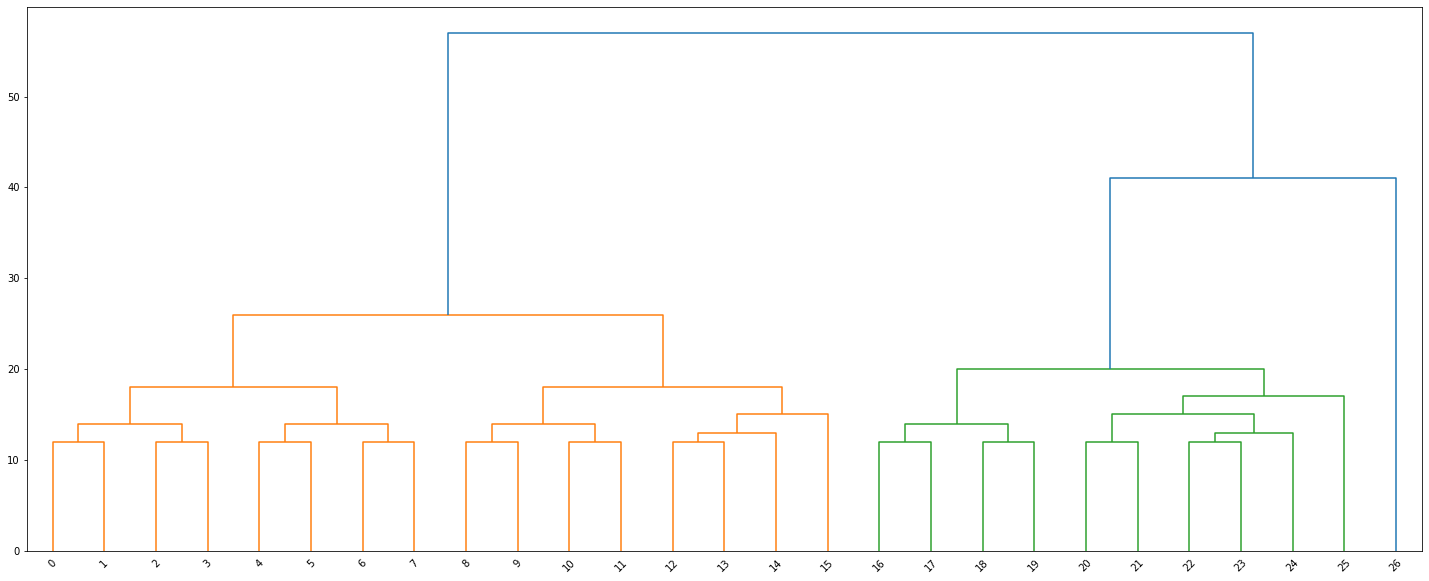

In [7]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
plt.show()